In [1]:
# Install necessary libraries (if required)
# !pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

# Import libraries
from google.colab import drive
import os
import zipfile
import random
import matplotlib.pyplot as plt
from PIL import Image

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Path to the shared dataset in Google Drive
# Update the path based on the shared folder structure in Drive
dataset_zip_path = "/content/drive/My Drive/PHOTOCL.zip"
dataset_dir = "/content/PHOTOCL/dataset_original"

# Verify the existence of the dataset in the shared location
if not os.path.exists(dataset_zip_path):
    raise FileNotFoundError(
        f"The dataset file was not found at {dataset_zip_path}. Ensure the path is correct and shared properly."
    )

# Extract the dataset if not already extracted
if not os.path.exists(dataset_dir):
    print("Extracting the dataset...")
    with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("Dataset extracted successfully!")

# Check the directory structure
print("Verifying dataset structure...")
for root, dirs, files in os.walk(dataset_dir):
    print(f"Directory: {root}")
    print(f"Sub-directories: {dirs}")
    print(f"Number of files: {len(files)}")
    break

Extracting the dataset...
Dataset extracted successfully!
Verifying dataset structure...
Directory: /content/PHOTOCL
Sub-directories: ['dataset_original']
Number of files: 0


In [4]:
dataset_dir = "/content/PHOTOCL/dataset_original"
for root, dirs, files in os.walk(dataset_dir):
    print(f"Directory: {root}")
    print(f"Sub-directories: {dirs}")
    print(f"Number of files: {len(files)}")
    break

Directory: /content/PHOTOCL/dataset_original
Sub-directories: ['Sketch', 'Text', 'Painting', 'Photo', 'Schematics']
Number of files: 0


Visualizing dataset samples...


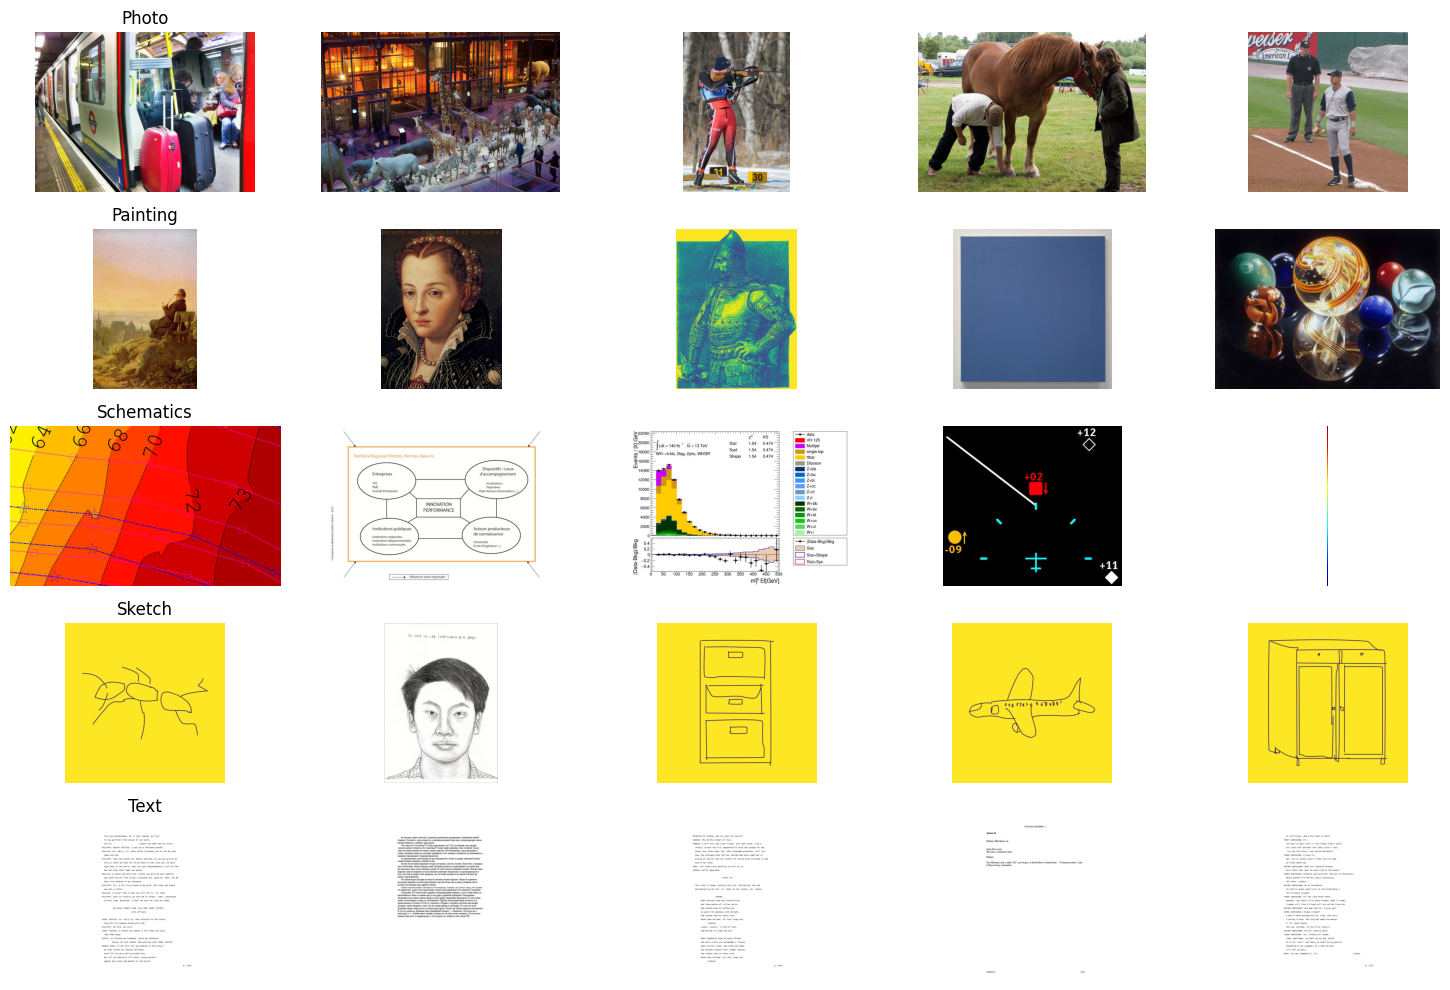

In [5]:
# Define classes and their respective directories
classes = ["Photo", "Painting", "Schematics", "Sketch", "Text"]
class_dirs = {cls: os.path.join(dataset_dir, cls) for cls in classes}

# Function to visualize samples from each class
def visualize_samples(class_dirs, num_samples=5):
    """Visualize random samples from each class."""
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))
    for i, cls in enumerate(classes):
        cls_path = class_dirs[cls]
        samples = random.sample(os.listdir(cls_path), num_samples)
        for j, sample in enumerate(samples):
            img_path = os.path.join(cls_path, sample)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(cls, fontsize=12)
    plt.tight_layout()
    plt.show()

# Visualize random samples from the dataset
print("Visualizing dataset samples...")
visualize_samples(class_dirs)

In [6]:
# Required Libraries
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

# Binary label mapping: Photo = 1, Others = 0
binary_mapping = {
    "Photo": 1,
    "Painting": 0,
    "Schematics": 0,
    "Sketch": 0,
    "Text": 0,
}

# Custom Dataset Class
class PHOTOCLDataset(Dataset):
    def __init__(self, class_dirs, binary_mapping, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform

        for cls, label in binary_mapping.items():
            cls_path = class_dirs[cls]
            for img_name in os.listdir(cls_path):
                self.samples.append(os.path.join(cls_path, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.labels[idx]

        # Open and transform the image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Load dataset and split into train/val/test
print("Loading dataset...")
dataset = PHOTOCLDataset(class_dirs, binary_mapping, transform=transform)

train_idx, temp_idx = train_test_split(range(len(dataset)), test_size=0.2, stratify=dataset.labels, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[dataset.labels[i] for i in temp_idx], random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Dataset split completed!")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Loading dataset...
Dataset split completed!
Train samples: 33120
Validation samples: 4140
Test samples: 4140


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Load Pretrained ResNet and Modify for Binary Classification
class BinaryResNet(nn.Module):
    def __init__(self, num_classes=1):  # Binary classification: single output (sigmoid activation)
        super(BinaryResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)  # Replace FC layer

    def forward(self, x):
        return self.model(x)

# Initialize model, loss, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryResNet(num_classes=1).to(device)  # Single output for binary classification
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


In [8]:
# Function to Train the Model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    train_loss_history, val_loss_history = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Convert to float for BCE

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Scheduler step
        scheduler.step()

        # Validation step
        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Store predictions and targets for evaluation
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy() > 0.5)
                val_targets.extend(labels.cpu().numpy())

        # Calculate metrics
        val_accuracy = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds)

        # Save loss history
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}, "
              f"Val F1-Score: {val_f1:.4f}")

    return train_loss_history, val_loss_history

In [9]:
# Function to Evaluate the Model
def evaluate_model(model, test_loader):
    model.eval()
    test_preds, test_targets = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            test_preds.extend(torch.sigmoid(outputs).cpu().numpy() > 0.5)
            test_targets.extend(labels.cpu().numpy())

    # Metrics
    accuracy = accuracy_score(test_targets, test_preds)
    f1 = f1_score(test_targets, test_preds)
    cm = confusion_matrix(test_targets, test_preds)
    print("Test Accuracy:", accuracy)
    print("Test F1-Score:", f1)
    print("\nClassification Report:")
    print(classification_report(test_targets, test_preds, target_names=["Others", "Photo"]))

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Others", "Photo"], yticklabels=["Others", "Photo"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Train the model
print("Training the model...")
train_loss_history, val_loss_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10
)

# Evaluate the model
print("Evaluating the model on the test set...")
evaluate_model(model, test_loader)

Training the model...
Epoch [1/10] - Train Loss: 0.0790, Val Loss: 0.0411, Val Accuracy: 0.9862, Val F1-Score: 0.9711
Epoch [2/10] - Train Loss: 0.0378, Val Loss: 0.0424, Val Accuracy: 0.9862, Val F1-Score: 0.9720
Epoch [3/10] - Train Loss: 0.0239, Val Loss: 0.0474, Val Accuracy: 0.9872, Val F1-Score: 0.9733
Epoch [4/10] - Train Loss: 0.0080, Val Loss: 0.0234, Val Accuracy: 0.9942, Val F1-Score: 0.9880
Epoch [5/10] - Train Loss: 0.0035, Val Loss: 0.0266, Val Accuracy: 0.9925, Val F1-Score: 0.9844
Epoch [6/10] - Train Loss: 0.0061, Val Loss: 0.0324, Val Accuracy: 0.9915, Val F1-Score: 0.9825
Epoch [7/10] - Train Loss: 0.0039, Val Loss: 0.0238, Val Accuracy: 0.9930, Val F1-Score: 0.9855
Epoch [8/10] - Train Loss: 0.0013, Val Loss: 0.0263, Val Accuracy: 0.9930, Val F1-Score: 0.9855
Epoch [9/10] - Train Loss: 0.0013, Val Loss: 0.0260, Val Accuracy: 0.9932, Val F1-Score: 0.9860
Epoch [10/10] - Train Loss: 0.0006, Val Loss: 0.0274, Val Accuracy: 0.9925, Val F1-Score: 0.9845
Evaluating the mo

UnidentifiedImageError: cannot identify image file '/content/PHOTOCL/dataset_original/Schematics/desktop.ini'

In [10]:
# Save the model
model_save_path = "/content/binary_classifier_resnet18.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/binary_classifier_resnet18.pth


In [11]:
from google.colab import files

# Download the saved model file
files.download(model_save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# Load the model
loaded_model = BinaryResNet(num_classes=1).to(device)
loaded_model.load_state_dict(torch.load(model_save_path))
print("Model loaded successfully!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully!


<ipython-input-12-0953f77d8f77>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_save_path))


In [13]:
loaded_model.eval()

BinaryResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [15]:
class PHOTOCLDataset(Dataset):
    def __init__(self, class_dirs, binary_mapping, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform

        for cls, label in binary_mapping.items():
            cls_path = class_dirs[cls]
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                # Only include valid image files
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    self.samples.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.labels[idx]

        # Open and transform the image
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            raise

In [16]:
# Recreate dataset and DataLoaders
dataset = PHOTOCLDataset(class_dirs, binary_mapping, transform=transform)

# Split dataset again
train_idx, temp_idx = train_test_split(range(len(dataset)), test_size=0.2, stratify=dataset.labels, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[dataset.labels[i] for i in temp_idx], random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Dataset and DataLoaders recreated successfully!")

Dataset and DataLoaders recreated successfully!


Test Accuracy: 0.9884057971014493
Test F1-Score: 0.9757575757575757

Classification Report:
              precision    recall  f1-score   support

      Others       0.99      1.00      0.99      3141
       Photo       0.98      0.97      0.98       999

    accuracy                           0.99      4140
   macro avg       0.99      0.98      0.98      4140
weighted avg       0.99      0.99      0.99      4140



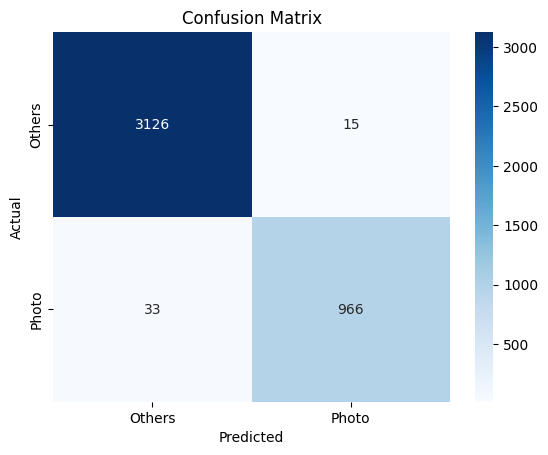

In [17]:
# Evaluate the saved model
evaluate_model(loaded_model, test_loader)

In [18]:
# Function to test a single image
def test_single_image(model, image_path, transform, class_names=["Others", "Photo"]):
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        if transform:
            input_tensor = transform(image).unsqueeze(0).to(device)

        # Make prediction
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            predicted = torch.sigmoid(output).item() > 0.5

        # Display the result
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Prediction: {class_names[int(predicted)]}")
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

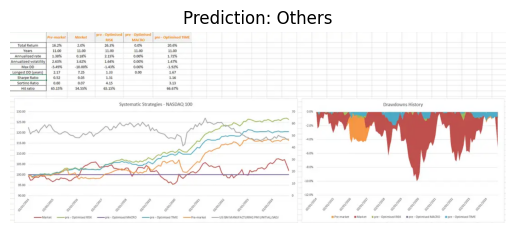

In [20]:
# Path to a test image (ensure this image exists in your test set or local folder)
test_image_path = "/content/image (1).png"  # Replace with an actual image path


test_single_image(loaded_model, test_image_path, transform)